In [1]:
import I2MC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [5]:
opt = dict()
# General variables for eye-tracking data
# maximum value of horizontal resolution in pixels
opt['xres'] = 1920.0
opt['yres'] = 1080.0  # maximum value of vertical resolution in pixels
# missing value for horizontal position in eye-tracking data (example data uses -xres). used throughout
# internal_helpers as signal for data loss
opt['missingx'] = -opt['xres']
# missing value for vertical position in eye-tracking data (example data uses -yres). used throughout
# internal_helpers as signal for data loss
opt['missingy'] = -opt['yres']
# sampling frequency of data (check that this value matches with values actually obtained from measurement!)
opt['freq'] = 250.0

# Variables for the calculation of visual angle
# These values are used to calculate noise measures (RMS and BCEA) of
# fixations. The may be left as is, but don't use the noise measures then.
# If either or both are empty, the noise measures are provided in pixels
# instead of degrees.
# screen size in cm
opt['scrSz'] = [55.0, 32.5]
# distance to screen in cm.
opt['disttoscreen'] = 65.0

# STEFFEN INTERPOLATION
# max duration (s) of missing values for interpolation to occur
opt['windowtimeInterp'] = 0.1
# amount of data (number of samples) at edges needed for interpolation
opt['edgeSampInterp'] = 2
# maximum displacement during missing for interpolation to be possible
opt['maxdisp'] = opt['xres'] * 0.2 * np.sqrt(2)

# # K-MEANS CLUSTERING
# time window (s) over which to calculate 2-means clustering (choose value so that max. 1 saccade can occur)
opt['windowtime'] = 0.2
# time window shift (s) for each iteration. Use zero for sample by sample processing
opt['steptime'] = 0.02
# maximum number of errors allowed in k-means clustering procedure before proceeding to next file
opt['maxerrors'] = 100
opt['downsamples'] = [2, 5, 10]
# use chebychev filter when down sampling? 1: yes, 0: no. requires signal processing toolbox. is what matlab's
# down sampling internal_helpers do, but could cause trouble (ringing) with the hard edges in eye-movement data
opt['downsampFilter'] = False

# # FIXATION DETERMINATION
# number of standard deviations above mean k-means weights will be used as fixation cutoff
opt['cutoffstd'] = 2.0
# number of MAD away from median fixation duration. Will be used to walk forward at fixation starts and backward at
# fixation ends to refine their placement and stop algorithm from eating into saccades
opt['onoffsetThresh'] = 3.0
# maximum Euclidean distance in pixels between fixations for merging
opt['maxMergeDist'] = 40.0
# maximum time in ms between fixations for merging
opt['maxMergeTime'] = 60.0
# minimum fixation duration after merging, fixations with shorter duration are removed from output
opt['minFixDur'] = 90.0

In [15]:
df_behavioral = pd.read_csv("./data/filteredData/filtered_data.csv")
df_fixation = pd.DataFrame([], columns=["Participant", "Algorithm", "Behavioral", "StartTime", "EndTime", "Duration", "IsOutlier", "SkillScore",
                                        "Fixation_startT", "Fixation_endT",  "Fixation_x", "Fixation_y", "Fixation_x_range", "Fixation_y_range"])
#iterate through each row
for index, row in tqdm(df_behavioral.iterrows(), total=len(df_behavioral)):
    #print("{}-{}: Fixation Calculation".format(row["Participant"], row["Algorithm"]))
    df_eyetracking = pd.read_csv(row["Eyetracking"])
    df_eyetracking["time"] = df_eyetracking["time"].astype(float)
    df_eyetracking["time"] = df_eyetracking["time"] - df_eyetracking["time"].iloc[0]
    # drop col
    df_eyetracking = df_eyetracking.drop(columns=["l_gaze_point_in_user_coordinate_system_x",
                                                  "l_gaze_point_in_user_coordinate_system_y",
                                                  "l_gaze_point_in_user_coordinate_system_z",
                                                  "r_gaze_point_in_user_coordinate_system_x",
                                                  "r_gaze_point_in_user_coordinate_system_y",
                                                  "r_gaze_point_in_user_coordinate_system_z",
                                                  "l_gaze_origin_in_user_coordinate_system_x",
                                                  "l_gaze_origin_in_user_coordinate_system_y",
                                                  "l_gaze_origin_in_user_coordinate_system_z",
                                                  "r_gaze_origin_in_user_coordinate_system_x",
                                                  "r_gaze_origin_in_user_coordinate_system_y",
                                                  "r_gaze_origin_in_user_coordinate_system_z"])

    df_eyetracking["l_display_x"] = df_eyetracking["l_display_x"].astype(float) * opt["xres"]
    df_eyetracking["l_display_y"] = df_eyetracking["l_display_y"].astype(float) * opt["yres"]
    df_eyetracking["r_display_x"] = df_eyetracking["r_display_x"].astype(float) * opt["xres"]
    df_eyetracking["r_display_y"] = df_eyetracking["r_display_y"].astype(float) * opt["yres"]
    df_eyetracking["l_valid"] = df_eyetracking["l_valid"].astype(int)
    df_eyetracking["r_valid"] = df_eyetracking["r_valid"].astype(int)

    df_eyetracking["l_miss_x"] = df_eyetracking.apply(lambda row: row["l_display_x"] < -opt["xres"] or row["l_display_x"] > 2 * opt["xres"], axis=1)
    df_eyetracking["l_miss_y"] = df_eyetracking.apply(lambda row: row["l_display_y"] < -opt["yres"] or row["l_display_y"] > 2 * opt["yres"], axis=1)
    df_eyetracking["r_miss_x"] = df_eyetracking.apply(lambda row: row["r_display_x"] < -opt["xres"] or row["r_display_x"] > 2 * opt["xres"], axis=1)
    df_eyetracking["r_miss_y"] = df_eyetracking.apply(lambda row: row["r_display_y"] < -opt["yres"] or row["r_display_y"] > 2 * opt["yres"], axis=1)

    df_eyetracking["l_miss"] = df_eyetracking.apply(lambda row: row["l_miss_x"] or row["l_miss_y"] or not row["l_valid"] >= 1, axis=1)
    df_eyetracking["r_miss"] = df_eyetracking.apply(lambda row: row["r_miss_x"] or row["r_miss_y"] or not row["r_valid"] >= 1, axis=1)

    df_eyetracking.loc[df_eyetracking["l_miss"], "l_display_x"] = opt["missingx"]
    df_eyetracking.loc[df_eyetracking["l_miss"], "l_display_y"] = opt["missingy"]
    df_eyetracking.loc[df_eyetracking["r_miss"], "r_display_x"] = opt["missingx"]
    df_eyetracking.loc[df_eyetracking["r_miss"], "r_display_y"] = opt["missingy"]

    df_eyetracking = df_eyetracking.drop(columns=["l_miss_x", "l_miss_y", "r_miss_x", "r_miss_y", "l_miss", "r_miss"])

    df_eyetracking.rename(columns={"l_display_x": "L_X",
                                   "l_display_y": "L_Y",
                                   "r_display_x": "R_X",
                                   "r_display_y": "R_Y",
                                   "l_valid" : "LValidity",
                                   "r_valid" : "RValidity"}, inplace=True)

    df_eyetracking["time"] = df_eyetracking["time"].astype(float) * 1000.0

    data = {}
    data["L_X"] = df_eyetracking["L_X"].to_numpy()
    data["L_Y"] = df_eyetracking["L_Y"].to_numpy()
    data["R_X"] = df_eyetracking["R_X"].to_numpy()
    data["R_Y"] = df_eyetracking["R_Y"].to_numpy()
    data["LValidity"] = df_eyetracking["LValidity"].to_numpy()
    data["RValidity"] = df_eyetracking["RValidity"].to_numpy()
    data["time"] = df_eyetracking["time"].to_numpy()
    # rename columns
    try:
        fix, data, par = I2MC.I2MC(data, opt, logging=False)
    except Exception as e:
        print('\t\tError in file: {}'.format(e))
        continue

    if not fix:
        print('{}-{}: Fixation calculation had some Problem'.format(row["Participant"], row["Algorithm"]))
        continue


    #f = I2MC.plot.plot_data_and_fixations(data, fix, fix_as_line=True, res=[opt['xres'], opt['yres']])

    participant = row["Participant"]
    algorithm = row["Algorithm"]
    behavioral = row["Behavioral"]
    start_time = row["StartTime"]
    end_time = row["EndTime"]
    duration = row["Duration"]
    is_outlier = row["IsOutlier"]
    skill_score = row["SkillScore"]

    fixations_start_time = np.array(fix["startT"])
    fixations_end_time = np.array(fix["endT"])
    fixations_x_pos = np.array(fix["xpos"])
    fixations_y_pos = np.array(fix["ypos"])
    fixations_x_range = np.array(fix["fixRangeX"])
    fixations_y_range = np.array(fix["fixRangeY"])

    df_fixation.loc[len(df_fixation)] = [participant, algorithm, behavioral, start_time, end_time, duration, is_outlier, skill_score,
                                         fixations_start_time, fixations_end_time, fixations_x_pos, fixations_y_pos, fixations_x_range, fixations_y_range]


  0%|          | 0/1072 [00:00<?, ?it/s]

C:\Users\jonas\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jonas\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\jonas\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\jonas\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jonas\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\jonas\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis,

In [41]:
df_fixation["Fixation_startT"] = df_fixation["Fixation_startT"].astype(str)
df_fixation["Fixation_endT"] = df_fixation["Fixation_endT"].astype(str)
df_fixation["Fixation_x"] = df_fixation["Fixation_x"].astype(str)
df_fixation["Fixation_y"] = df_fixation["Fixation_y"].astype(str)
df_fixation["Fixation_x_range"] = df_fixation["Fixation_x_range"].astype(str)
df_fixation["Fixation_y_range"] = df_fixation["Fixation_y_range"].astype(str)
df_fixation.to_csv("./data/filteredData/fixation_stats.csv", index=False, sep=";")

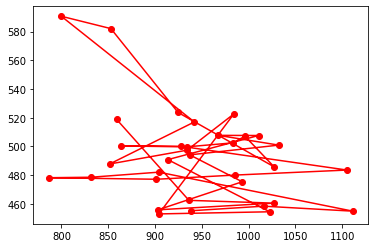

In [42]:
x = df_fixation.iloc[0].Fixation_x
y = df_fixation.iloc[0].Fixation_y
x = eval("[" + ",".join([value.strip("[") for value in x.replace(" ", ",").replace("\n", ",").split(",") if len(value) > 0 and value!="["]))
y = eval("[" + ",".join([value.strip("[") for value in y.replace(" ", ",").replace("\n", ",").split(",") if len(value) > 0 and value!="["]))
plt.plot(x, y, 'o-r')